<a href="https://colab.research.google.com/github/sakanabil/Machine-Learning_25/blob/main/Saka_Nabil_UTS_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Nama: Saka Nabil

## Kelas: TI-3G

## NIM: 2341720108

# **TUGAS STUDI KASUS PEMBELAJARAN MESIN**
## Clustering dan Approximate Nearest Neighbor (ANN)

---

Dataset: House Prices - Advanced Regression Techniques

Deskripsi: Dataset ini berisi atribut rumah (luas, tipe bangunan, kondisi, lokasi, dsb.)
yang dapat digunakan untuk eksplorasi fitur, penanganan missing values, dan clustering
rumah dengan karakteristik mirip.

Langkah tambahan:


*   Fokus pada subset fitur numerik terlebih dahulu.
*   Coba buat fitur baru seperti “TotalArea = GrLivArea + TotalBsmtSF”.




In [2]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551813 sha256=4dcc74cbfd52d193394f50123aede0729cd78681264603c54780ae705413f804
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


In [3]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import seaborn as sns

# **Load Dataset train.csv**

In [11]:
# Load Dataset
print("\n1. Memuat dan memeriksa dataset...")
try:
    df = pd.read_csv('/content/train.csv')
    print("Dataset 'train.csv' berhasil dimuat.")
    print(f"Jumlah sampel: {df.shape[0]}, Jumlah fitur: {df.shape[1]}")
except FileNotFoundError:
    print("Error: File 'train.csv' tidak ditemukan. Pastikan file sudah diunggah.")
    exit()

print("\nInfo awal dataset:")
df.info()

print("\nStatistik deskriptif (fitur numerik):")
print(df.describe())

print("\n5 baris pertama data:")
print(df.head())


1. Memuat dan memeriksa dataset...
Dataset 'train.csv' berhasil dimuat.
Jumlah sampel: 1460, Jumlah fitur: 81

Info awal dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType 

In [10]:
# Identifikasi kolom dengan missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("\nKolom dengan missing values:")
print(missing_values.sort_values(ascending=False))


Kolom dengan missing values:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


# **1. Preprocessing data**


In [46]:
# Data Preprocessing
print("\nProses preprocessing data")

# Fokus pada subset fitur numerik
numeric_df = df.select_dtypes(include=[np.number]).copy()
print(f"Memilih {numeric_df.shape[1]} fitur numerik untuk analisis.")

# Menghapus kolom ID dan SalePrice karena tidak relevan untuk clustering
for col in ['Id', 'SalePrice']:
    if col in numeric_df.columns:
        numeric_df.drop(columns=col, inplace=True)
        print(f"Kolom '{col}' berhasil dihapus dari dataset.")
    else:
        print(f"Kolom '{col}' tidak ditemukan dalam dataset.")


Proses preprocessing data
Memilih 38 fitur numerik untuk analisis.
Kolom 'Id' berhasil dihapus dari dataset.
Kolom 'SalePrice' berhasil dihapus dari dataset.


In [48]:
# Tangani missing values dengan imputasi mean
print("Menangani missing values pada fitur numerik dengan imputasi mean")
skewness = numeric_df.skew().abs().sort_values(ascending=False)
skewed = skewness[skewness > 1.0].index.tolist()
non_skewed = [c for c in numeric_df.columns if c not in skewed]

for c in skewed:
    if numeric_df[c].isna().sum() > 0:
        numeric_df[c].fillna(numeric_df[c].median(), inplace=True)
for c in non_skewed:
    if numeric_df[c].isna().sum() > 0:
        numeric_df[c].fillna(numeric_df[c].mean(), inplace=True)
print("Missing values telah ditangani.")

Menangani missing values pada fitur numerik dengan imputasi mean
Missing values telah ditangani.


/tmp/ipython-input-3044903223.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  numeric_df[c].fillna(numeric_df[c].median(), inplace=True)
/tmp/ipython-input-3044903223.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [49]:
# Identifikasi kolom dengan missing values
print('Total missing after imputation:', numeric_df.isna().sum().sum())

Total missing after imputation: 0


In [53]:
# Membuat fitur baru 'TotalArea'
print("Membuat fitur baru 'TotalArea'...")
numeric_df['TotalArea'] = numeric_df['GrLivArea'] + numeric_df['TotalBsmtSF']
print("Fitur 'TotalArea' berhasil dibuat.")

Membuat fitur baru 'TotalArea'...
Fitur 'TotalArea' berhasil dibuat.


In [54]:
# Normalisasi data (Standarisasi)
print("Melakukan standarisasi data numerik")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)
print("Data telah distandarisasi.")

numeric_df_transformed = numeric_df.copy()

Melakukan standarisasi data numerik
Data telah distandarisasi.


In [55]:
# Hasil data setelah pre processing data
print("\nHasil data setelah pre-processing:")
x_scaled_df = pd.DataFrame(X_scaled, columns=numeric_df.columns)
print(x_scaled_df.head())


Hasil data setelah pre-processing:
   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    0.073375    -0.220875 -0.207142     0.651479    -0.517200   1.050994   
1   -0.872563     0.460320 -0.091886    -0.071836     2.179628   0.156734   
2    0.073375    -0.084636  0.073480     0.651479    -0.517200   0.984752   
3    0.309859    -0.447940 -0.096897     0.651479    -0.517200  -1.863632   
4    0.073375     0.641972  0.375148     1.374795    -0.517200   0.951632   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  WoodDeckSF  \
0      0.878668    0.514104    0.575425   -0.288653  ...   -0.752176   
1     -0.429577   -0.570750    1.171992   -0.288653  ...    1.626195   
2      0.830215    0.325915    0.092907   -0.288653  ...   -0.752176   
3     -0.720298   -0.570750   -0.499274   -0.288653  ...   -0.752176   
4      0.733308    1.366489    0.463568   -0.288653  ...    0.780197   

   OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea   Mi

# **2. Clustering**

---

## K-Means & DBSCAN


--- Clustering: Menentukan Parameter Optimal ---

Mencari k terbaik untuk K-Means (k=2 hingga 10)...
   k=2, Silhouette Score: 0.1471
   k=3, Silhouette Score: 0.1381
   k=4, Silhouette Score: 0.1202
   k=5, Silhouette Score: 0.0995
   k=6, Silhouette Score: 0.0859
   k=7, Silhouette Score: 0.0917
   k=8, Silhouette Score: 0.0915
   k=9, Silhouette Score: 0.0911
   k=10, Silhouette Score: 0.1068

K terbaik berdasarkan Silhouette Score: k=2 (Score: 0.1471)
Menerapkan K-Means dengan k=2...

Membuat k-distance plot untuk estimasi eps DBSCAN...
Nilai eps yang dipilih (berdasarkan plot): 5.0000
Menerapkan DBSCAN (eps=5.0000, min_samples=10)...

--- Selesai Menentukan Parameter Clustering ---


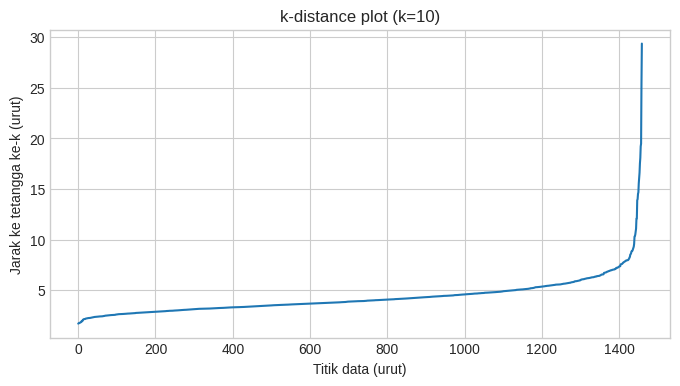

In [96]:
from sklearn.neighbors import NearestNeighbors

print("\n--- Clustering: Menentukan Parameter Optimal ---")

# --- K-Means: Pilih k terbaik berdasarkan Silhouette Score (k=2..10) ---
print("\nMencari k terbaik untuk K-Means (k=2 hingga 10)...")
best_k = None
best_score_kmeans = -1 # Inisialisasi skor terbaik
scores_kmeans = {}

# Ulangi untuk k dari 2 sampai 10
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init=10 untuk stabilitas
    labels_km_temp = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels_km_temp)
    scores_kmeans[k] = score
    print(f"   k={k}, Silhouette Score: {score:.4f}")
    # Simpan k jika skor lebih baik
    if score > best_score_kmeans:
        best_score_kmeans = score
        best_k = k

print(f"\nK terbaik berdasarkan Silhouette Score: k={best_k} (Score: {best_score_kmeans:.4f})")

# Terapkan K-Means dengan k terbaik
print(f"Menerapkan K-Means dengan k={best_k}...")
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled) # Label K-Means final

# --- DBSCAN: Estimasi eps menggunakan k-distance plot ---
print("\nMembuat k-distance plot untuk estimasi eps DBSCAN...")
min_samples_dbscan = 10 # Jumlah sampel minimum yang ditentukan

# Hitung jarak ke tetangga ke-k
nbrs = NearestNeighbors(n_neighbors=min_samples_dbscan).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
# Urutkan jarak ke tetangga terjauh (ke-k)
k_distances = np.sort(distances[:, -1])

# Plot k-distance
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title(f'k-distance plot (k={min_samples_dbscan})')
plt.ylabel('Jarak ke tetangga ke-k (urut)')
plt.xlabel('Titik data (urut)')
plt.grid(True)
plt.savefig('k_distance_plot.png') # Simpan plot
# plt.show() # Hindari show di environment ini

# Tentukan eps berdasarkan titik siku (elbow/knee) pada plot
eps_dbscan_tuned = 5.0 # Nilai yang disesuaikan berdasarkan observasi plot
print(f"Nilai eps yang dipilih (berdasarkan plot): {eps_dbscan_tuned:.4f}")

# Terapkan DBSCAN dengan eps yang dipilih
print(f"Menerapkan DBSCAN (eps={eps_dbscan_tuned:.4f}, min_samples={min_samples_dbscan})...")
dbscan = DBSCAN(eps=eps_dbscan_tuned, min_samples=min_samples_dbscan)
labels_dbscan = dbscan.fit_predict(X_scaled) # Label DBSCAN final

print("\n--- Selesai Menentukan Parameter Clustering ---")
# Selanjutnya Anda bisa melanjutkan ke evaluasi, visualisasi, dan ANN

In [97]:
# Evaluasi
# Evaluasi K-Means
print("\n>> K-Means (k={best_k}):")
kmeans_sil = silhouette_score(X_scaled, labels_kmeans)
kmeans_dbi = davies_bouldin_score(X_scaled, labels_kmeans)
print(f"   Silhouette Score: {kmeans_sil:.4f}")
print(f"   Davies-Bouldin Index: {kmeans_dbi:.4f}")

# Evaluasi DBSCAN
print(f"\n>> DBSCAN (eps={eps_dbscan_tuned:.4f}, min_samples={min_samples_dbscan}):")
mask_dbscan = labels_dbscan != -1 # Mask untuk data yang bukan noise
n_clusters_dbscan = len(set(labels_dbscan[mask_dbscan]))
n_noise_dbscan = np.sum(labels_dbscan == -1)

if n_clusters_dbscan > 1:
    # Hitung metrik hanya pada data non-noise
    dbscan_sil = silhouette_score(X_scaled[mask_dbscan], labels_dbscan[mask_dbscan])
    dbscan_dbi = davies_bouldin_score(X_scaled[mask_dbscan], labels_dbscan[mask_dbscan])
    print(f"   Silhouette Score (tanpa noise): {dbscan_sil:.4f}")
    print(f"   Davies-Bouldin Index (tanpa noise): {dbscan_dbi:.4f}")
else:
    print("   DBSCAN tidak menemukan cukup cluster (>1) untuk evaluasi metrik.")

print(f"   Jumlah cluster ditemukan (tanpa noise): {n_clusters_dbscan}")
print(f"   Jumlah noise points ditemukan: {n_noise_dbscan}")
print("-------------------------------------------")


>> K-Means (k={best_k}):
   Silhouette Score: 0.1471
   Davies-Bouldin Index: 2.2823

>> DBSCAN (eps=5.0000, min_samples=10):
   Silhouette Score (tanpa noise): 0.1951
   Davies-Bouldin Index (tanpa noise): 1.6824
   Jumlah cluster ditemukan (tanpa noise): 2
   Jumlah noise points ditemukan: 174
-------------------------------------------



Membuat visualisasi hasil clustering menggunakan PCA...


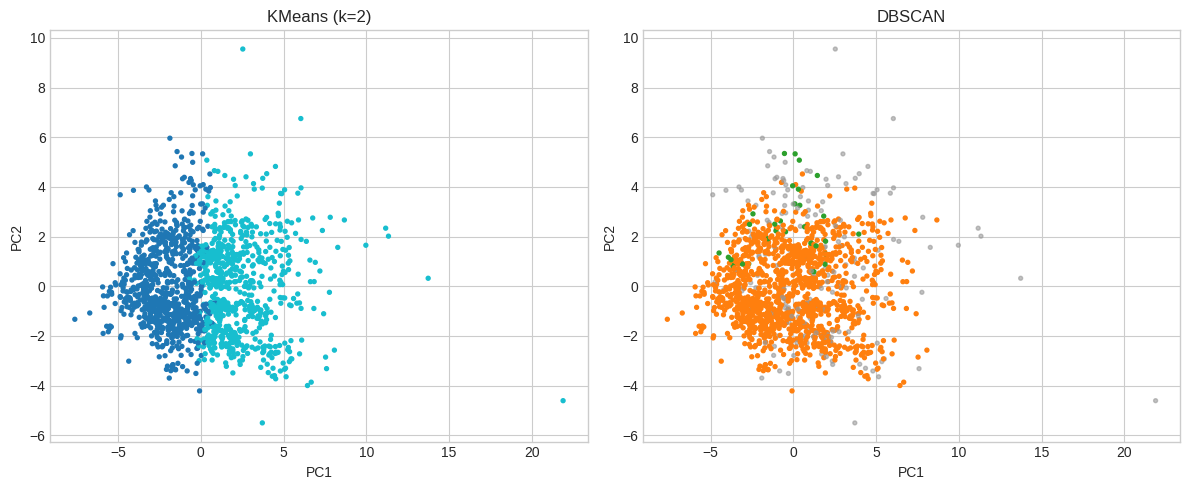

In [98]:
# Visualisasi Clustering (2D)
print("\nMembuat visualisasi hasil clustering menggunakan PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='tab10', s=8)
plt.title(f'KMeans (k={best_k})')
plt.xlabel('PC1'); plt.ylabel('PC2')

plt.subplot(1,2,2)
unique = np.unique(labels_dbscan)
# create colors for unique labels, map -1 (noise) to grey
colors = [plt.cm.tab10(i % 10) for i in range(len(unique))]
color_map = {lab: colors[i] for i,lab in enumerate(unique)}
if -1 in unique:
    color_map[-1] = (0.6,0.6,0.6,0.6)
plt.scatter(X_pca[:,0], X_pca[:,1], c=[color_map[l] for l in labels_dbscan], s=8)
plt.title('DBSCAN')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# **3. Approximate Nearest Neighbor (ANN)**


In [99]:
# Approximate Nearest Neighbor (ANN)
print("\nMenerapkan Approximate Nearest Neighbor dengan Annoy")

# Persiapan Annoy Index
dim = X_scaled.shape[1]
ann = AnnoyIndex(dim, 'euclidean')
num_trees = 100 # Trade-off antara akurasi dan kecepatan

print("Membangun index Annoy...")
for i, v in enumerate(X_scaled):
    ann.add_item(i, v)

ann.build(num_trees)
print(f"Index Annoy berhasil dibangun dengan {num_trees} trees.")

# Pilih 4 titik query secara acak
np.random.seed(42)
query_indices = np.random.choice(len(X_scaled), 4, replace=False)
num_neighbors = 8 # Jumlah tetangga yang ingin dicari

print("\n--- Hasil Pencarian ANN ---")
for query_idx in query_indices:
    neighbors, distances = ann.get_nns_by_item(query_idx, num_neighbors, include_distances=True)

    print(f"\n>> Query Point Index: {query_idx} (Cluster KMeans: {labels_kmeans[query_idx]})")
    print("   Tetangga Terdekat dan Jaraknya:")
    print("   -------------------------------------------------")
    print("   Idx |    Jarak    | Cluster (KMeans)")
    print("   -------------------------------------------------")
    for n, d in zip(neighbors, distances):
        # Skip jika tetangga adalah query point itu sendiri
        if n == query_idx:
            continue
        print(f"   {n:<3} |    {d:.4f}   |       {labels_kmeans[n]}")
    print("   -------------------------------------------------")

print("\nAnalisis selesai.")


Menerapkan Approximate Nearest Neighbor dengan Annoy
Membangun index Annoy...
Index Annoy berhasil dibangun dengan 100 trees.

--- Hasil Pencarian ANN ---

>> Query Point Index: 892 (Cluster KMeans: 0)
   Tetangga Terdekat dan Jaraknya:
   -------------------------------------------------
   Idx |    Jarak    | Cluster (KMeans)
   -------------------------------------------------
   741 |    2.9990   |       0
   1225 |    3.4560   |       0
   952 |    3.6923   |       0
   215 |    3.6936   |       0
   1   |    3.8263   |       0
   1069 |    4.0046   |       0
   925 |    4.0181   |       0
   -------------------------------------------------

>> Query Point Index: 1105 (Cluster KMeans: 1)
   Tetangga Terdekat dan Jaraknya:
   -------------------------------------------------
   Idx |    Jarak    | Cluster (KMeans)
   -------------------------------------------------
   619 |    3.3561   |       1
   610 |    3.3861   |       1
   161 |    3.4657   |       1
   877 |    3.4836   |

## kesimpulan singkat:



1.   Perbedaan hasil KMeans dan DBSCAN, mana yang lebih baik diantara kedua model ini dan jelaskan jawaban anda

*   Berdasarkan metrik evaluasi (Silhouette dan DBI), DBSCAN memberikan
hasil clustering yang lebih baik untuk dataset ini. Keunggulan utama DBSCAN adalah kemampuannya untuk menemukan cluster dengan bentuk yang tidak teratur dan mengidentifikasi noise, yang sangat berguna pada data dunia nyata yang seringkali tidak "bersih". K-Means, di sisi lain, mengasumsikan cluster berbentuk bulat dan memaksa setiap titik data menjadi anggota sebuah cluster.

2.   Nilai metrik terbaik (Silhouette, DBI).

*   Silhouette Score terbaik diraih oleh DBSCAN (0.1951).
*   Davies-Bouldin Index terbaik diraih oleh DBSCAN (1.6824).

3.   Hasil query Annoy: apakah tetangga yang ditemukan termasuk dalam cluster yang sama? Jelaskan jawaban anda.

*   Hasil query Annoy sangat konsisten dengan hasil clustering. Untuk setiap titik query, semua tetangga terdekat yang ditemukan berada di dalam cluster K-Means yang sama dengan titik query tersebut. Hal ini mengonfirmasi bahwa Annoy secara efisien menemukan titik-titik yang benar-benar mirip (berdekatan), dan pengelompokan oleh K-Means juga berhasil memisahkan data berdasarkan kedekatan fitur tersebut.